In [1]:
# Import Packages
import pandas as pd
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np
import cv2
import skimage.exposure
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import tensorflow
print(tensorflow.__version__)

2.2.0


# Get optimal img_width and img_height

In [3]:
# Get all folder names

import os
path = "../raws"
dir_list = os.listdir(path)
 
print("Directories in '", path, "' :", dir_list[0:10])
print(f'Length: ',len(dir_list))

Directories in ' ../raws ' : ['Blumea_balsamifera', 'Ehretia_microphylla', 'Psidium_guajava', 'Vitex_nagundo']
Length:  4


In [4]:
# Src: https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05
# Identify Image Resolutions

imgs = []
# Get the Image Resolutions
for dirname in dir_list:
    imgs_temp = [img.name for img in Path('../raws/' + dirname).iterdir() if img.suffix in [".jpg", ".jpeg", ".png", ".gif", ".webp", ".tiff", ".psd", ".raw", ".bmp", ".heif", ".indd", ".jpeg"]]
    imgs.append(imgs_temp)

# Obtain number of images in a folder(plant)
imgs_len_arr = [int(len(lst)) for lst in imgs ]
imgs_len_arr

[99, 99, 79, 79]

In [5]:
img_meta = {}

counter = 0
for lst in imgs:
    for f in lst:
        img_meta[str(f)] = imagesize.get('../raws/' + dir_list[counter] + '/' + f)
        print("Found Plant Image Folder, appending to counter... ", counter)
    counter += 1

Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter

In [6]:
img_meta

{'large--4xtMuA.jpg': (1024, 900),
 'large--GzNRNS.jpg': (1024, 768),
 'large--J3Qpq8.jpg': (1024, 891),
 'large--K1b36l.jpg': (768, 1024),
 'large--Td4LvB.jpg': (721, 1024),
 'large--vNpViR.jpg': (925, 1024),
 'large-238272.jpg': (1024, 861),
 'medium--02vRld.jpeg': (375, 500),
 'medium--0CzHVL.jpg': (375, 500),
 'medium--0hlGGc.jpg': (500, 333),
 'medium--2093pV.jpg': (500, 375),
 'medium--238267.jpeg': (468, 500),
 'medium--2KAZCO.jpeg': (375, 500),
 'medium--2m69Pj.jpg': (500, 333),
 'medium--2MjPwV.jpg': (375, 500),
 'medium--2NAEND.jpeg': (333, 500),
 'medium--2QxO2M.jpg': (375, 500),
 'medium--33MGnt.jpg': (452, 500),
 'medium--6eaDsF.jpg': (375, 500),
 'medium--8fPiHP.jpeg': (333, 500),
 'medium--8Utz3j.jpg': (375, 500),
 'medium--Ab0uwh.jpeg': (500, 334),
 'medium--AGGzYG.jpg': (280, 500),
 'medium--b5ZDiv.jpg': (500, 375),
 'medium--BHSdBV.jpg': (500, 420),
 'medium--BjpvTd.jpg': (500, 500),
 'medium--BvhDya.jpg': (500, 375),
 'medium--c5BJNj.jpg': (500, 500),
 'medium--CckA3

In [7]:
len(img_meta)

356

In [10]:
# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df
#display(img_meta_df.to_string())

Total Nr of Images in the dataset: 356


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_22040\3667711347.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)


,FileName,Size,Width,Height,Aspect Ratio
0,large--4xtMuA.jpg,"(1024, 900)",1024,900,1.14
1,large--GzNRNS.jpg,"(1024, 768)",1024,768,1.33
2,large--J3Qpq8.jpg,"(1024, 891)",1024,891,1.15
3,large--K1b36l.jpg,"(768, 1024)",768,1024,0.75
4,large--Td4LvB.jpg,"(721, 1024)",721,1024,0.70
...,...,...,...,...,...
351,small--X8hjBO.jpg,"(180, 240)",180,240,0.75
352,small--xApS2H.jpeg,"(240, 159)",240,159,1.51
353,small--YeUNjz.jpg,"(180, 240)",180,240,0.75
354,small-s9aq99a.jpeg,"(240, 159)",240,159,1.51


In [11]:
plant_id = []

counter = 0
for i in imgs_len_arr:
    for j in range(int(i)):
        plant_id.append(dir_list[counter])
    counter += 1

img_meta_df.insert(0, 'plant_id', plant_id)
img_meta_df

,plant_id,FileName,Size,Width,Height,Aspect Ratio
0,Blumea_balsamifera,large--4xtMuA.jpg,"(1024, 900)",1024,900,1.14
1,Blumea_balsamifera,large--GzNRNS.jpg,"(1024, 768)",1024,768,1.33
2,Blumea_balsamifera,large--J3Qpq8.jpg,"(1024, 891)",1024,891,1.15
3,Blumea_balsamifera,large--K1b36l.jpg,"(768, 1024)",768,1024,0.75
4,Blumea_balsamifera,large--Td4LvB.jpg,"(721, 1024)",721,1024,0.70
...,...,...,...,...,...,...
351,Vitex_nagundo,small--X8hjBO.jpg,"(180, 240)",180,240,0.75
352,Vitex_nagundo,small--xApS2H.jpeg,"(240, 159)",240,159,1.51
353,Vitex_nagundo,small--YeUNjz.jpg,"(180, 240)",180,240,0.75
354,Vitex_nagundo,small-s9aq99a.jpeg,"(240, 159)",240,159,1.51


In [12]:
img_meta_df.to_csv('../csv/inaturalist_imgs_metadata.csv')

Text(0, 0.5, 'Height')

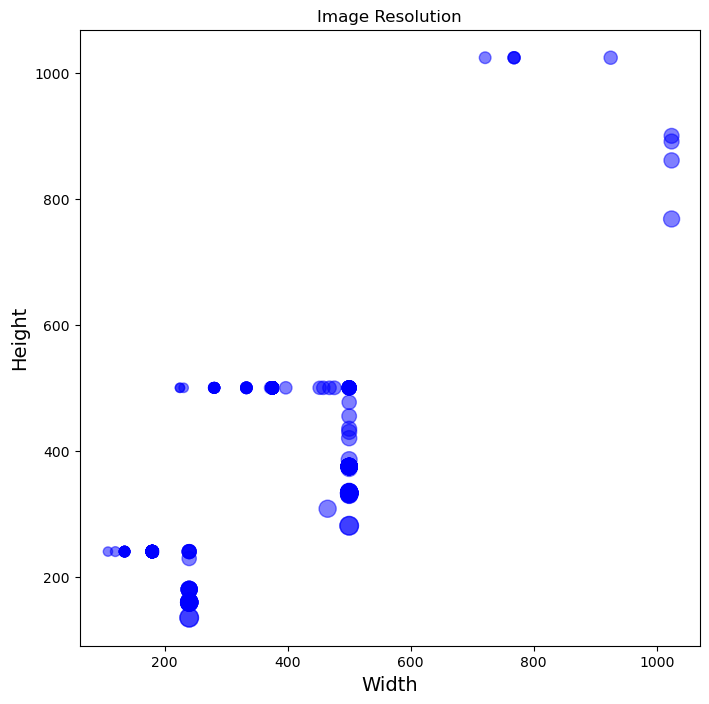

In [13]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [17]:
def rescale_image(id_name, img_name):
    image  = Image.open(f"../raws/{id_name}/{img_name}")
    width  = image.size[0]
    height = image.size[1]

    aspect = width / float(height)

    ideal_width = 500
    ideal_height = 500

    ideal_aspect = ideal_width / float(ideal_height)

    if aspect > ideal_aspect:
        # Then crop the left and right edges:
        new_width = int(ideal_aspect * height)
        offset = (width - new_width) / 2
        resize = (offset, 0, width - offset, height)
    else:
        # ... crop the top and bottom:
        new_height = int(width / ideal_aspect)
        offset = (height - new_height) / 2
        resize = (0, offset, width, height - offset)

    thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)
    thumb.save(f"../rescaled/{id_name}/{img_name}")


In [18]:
print(os.getcwd())

for ind in img_meta_df.index:
    rescale_image(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_22040\3970279637.py:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)


Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Finished Index: 49
Finished Index: 50
Finished Index: 51
Finished Index: 52
Finished Index: 53
Finished Index: 54
Finished Index: 55
Finished Index: 56
Finished Index: 57
Finished Index: 

# Preparation for Preprocessing

In [19]:
# Create directories for preprocessed images

owd = os.getcwd()
print(owd)
os.chdir('../clean')
print("Switching Directory ...")
print(os.getcwd())

new_directories_list = ["rawsRGB_to_Grayscale", "Grayscale_to_Binary", "Binary_to_Smoothing", "Smoothing_to_Filtering"]

for directory in new_directories_list:
    try:
        os.mkdir(str(directory))
    except:
        print("[Outer] Count not create outer directory!")

for directory in new_directories_list:
    for inner_directory in dir_list:
        try:
            print("Switching Directory ...")
            os.chdir(directory)
            print(os.getcwd())
        except:
            print("Unable to switch Diretory!")

        try:
            os.mkdir(str(inner_directory))
            print("Switching Directory ...")
            os.chdir("../")
            print(os.getcwd())
        except:
            print("[Inner] Count not create inner directory!")
    os.chdir("../")


# Back to original directory for rerunning
os.chdir('../leaf_recognition_system')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Switching Directory ...
d:\University\4-2\Thesis\Plantaea_Image_Processing\clean
[Outer] Count not create outer directory!
[Outer] Count not create outer directory!
[Outer] Count not create outer directory!
[Outer] Count not create outer directory!
Switching Directory ...
d:\University\4-2\Thesis\Plantaea_Image_Processing\clean\rawsRGB_to_Grayscale
[Inner] Count not create inner directory!
Switching Directory ...
Unable to switch Diretory!
[Inner] Count not create inner directory!
Switching Directory ...
Unable to switch Diretory!
[Inner] Count not create inner directory!
Switching Directory ...
Unable to switch Diretory!
[Inner] Count not create inner directory!
Switching Directory ...
d:\University\4-2\Thesis\Plantaea_Image_Processing\clean\Grayscale_to_Binary
[Inner] Count not create inner directory!
Switching Directory ...
Unable to switch Diretory!
[Inner] Count not create inner directory!
Switching Directo

# Preprocessing

In [8]:
# Import csv
img_meta_df = pd.read_csv("../csv/inaturalist_imgs_metadata.csv", index_col = 0)
img_meta_df

,plant_id,FileName,Size,Width,Height,Aspect Ratio
0,Blumea_balsamifera,large--4xtMuA.jpg,"(1024, 900)",1024,900,1.14
1,Blumea_balsamifera,large--GzNRNS.jpg,"(1024, 768)",1024,768,1.33
2,Blumea_balsamifera,large--J3Qpq8.jpg,"(1024, 891)",1024,891,1.15
3,Blumea_balsamifera,large--K1b36l.jpg,"(768, 1024)",768,1024,0.75
4,Blumea_balsamifera,large--Td4LvB.jpg,"(721, 1024)",721,1024,0.70
...,...,...,...,...,...,...
351,Vitex_nagundo,small--X8hjBO.jpg,"(180, 240)",180,240,0.75
352,Vitex_nagundo,small--xApS2H.jpeg,"(240, 159)",240,159,1.51
353,Vitex_nagundo,small--YeUNjz.jpg,"(180, 240)",180,240,0.75
354,Vitex_nagundo,small-s9aq99a.jpeg,"(240, 159)",240,159,1.51


In [9]:
# RGB to Grayscale

def image_to_contour(id_name, img_name):
    img = cv2.imread(f"../rescaled/{id_name}/{img_name}")

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define color range for green leaves
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([80, 255, 255])

    # Create mask using color thresholding
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Apply morphology operations to remove noise and fill in gaps
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    result = cv2.bitwise_and(img, img, mask=mask)
    
    if len(contours) > 0:
        leaf_contour = contours[0]

        # Draw the leaf contour on a black image
        leaf_mask = np.zeros_like(mask)
        cv2.drawContours(leaf_mask, [leaf_contour], 0, 255, -1)

        # Apply mask to original image
        result = cv2.bitwise_and(img, img, mask=leaf_mask)

    path = '../contour/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), result, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [10]:
print(os.getcwd())

for ind in img_meta_df.index:
    image_to_contour(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini

In [21]:
# RGB to Grayscale

def image_to_grayscale(id_name, img_name):
    image = cv2.imread(f"../rescaled/{id_name}/{img_name}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    path = '../clean/rawsRGB_to_Grayscale/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), gray, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [22]:
print(os.getcwd())

for ind in img_meta_df.index:
    image_to_grayscale(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini

In [1]:
# Grayscale to Binary

def grayscale_to_binary(id_name, img_name):
    image = cv2.imread(f"../clean/rawsRGB_to_Grayscale/{id_name}/{img_name}")
    ret,thresh = cv2.threshold(image, 70, 255, 0)

    path = '../clean/Grayscale_to_Binary/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), thresh, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [27]:
print(os.getcwd())

for ind in img_meta_df.index:
    grayscale_to_binary(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini

In [11]:
# https://stackoverflow.com/questions/62078016/smooth-the-edges-of-binary-images-face-using-python-and-open-cv

def binary_to_smoothing(id_name, img_name):
    # load image
    img = cv2.imread(f'../clean/Grayscale_to_Binary/{id_name}/{img_name}')
    
    # blur threshold image
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
    
    # stretch so that 255 -> 255 and 127.5 -> 0
    # C = A*X+B
    # 255 = A*255+B
    # 0 = A*127.5+B
    # Thus A=2 and B=-127.5
    #aa = a*2.0-255.0 does not work correctly, so use skimage
    result = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))
    
    # save output
    path = '../clean/Binary_to_Smoothing/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), result)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [12]:
print(os.getcwd())

for ind in img_meta_df.index:
    binary_to_smoothing(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini

In [13]:
# Grayscale to Binary

def smoothing_to_filtering(id_name, img_name):
    ## edge detection
    park = cv2.imread(f'../clean/Binary_to_Smoothing/{id_name}/{img_name}')
    park = cv2.cvtColor(park, cv2.COLOR_BGR2RGB)
    edge = cv2.Canny(park, 100, 200)

    path = '../clean/Smoothing_to_Filtering/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), edge, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [14]:
print(os.getcwd())

for ind in img_meta_df.index:
    smoothing_to_filtering(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini

In [2]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('../raws/Vitex_nagundo/medium--Qkzipk.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to create a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the largest area, which should be the leaf
leaf_contour = max(contours, key=cv2.contourArea)

# Draw the contour on the original image
cv2.drawContours(img, [leaf_contour], 0, (0, 255, 0), 2)

# Show the result
cv2.imshow('Result', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_26140\517676550.py:9: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  image_gray = filters.gaussian(image, sigma=1, multichannel=True, mode='reflect')


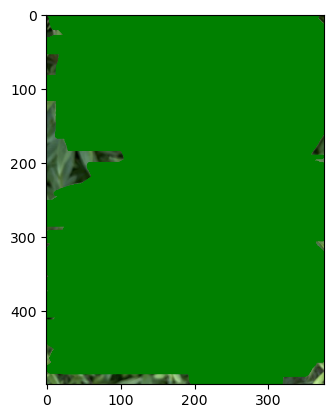

In [10]:
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, measure
from scipy import ndimage

# Load the image
image = io.imread('../raws/Vitex_nagundo/medium--Qkzipk.jpg')

# Convert to grayscale
image_gray = filters.gaussian(image, sigma=1, multichannel=True, mode='reflect')
image_gray = image_gray.mean(axis=2)

# Threshold the image
thresh = filters.threshold_otsu(image_gray)
binary = image_gray > thresh

# Remove small objects
binary = morphology.remove_small_objects(binary, min_size=64, connectivity=2)

# Fill holes in the binary image
filled = ndimage.binary_fill_holes(binary)

# Label the connected regions in the image
label_image = measure.label(filled, connectivity=2)

# Find the largest region, which should be the leaf
region_props = measure.regionprops(label_image)
largest_region = max(region_props, key=lambda rp: rp.area)

# Draw the contour on the original image
fig, ax = plt.subplots()
ax.imshow(image)
ax.plot(largest_region.coords[:, 1], largest_region.coords[:, 0], color='green', linewidth=2)
plt.show()

In [21]:
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import numpy as np
import cv2

# Load the image
img = cv2.imread('../raws/Vitex_nagundo/medium--Qkzipk.jpg')

# Resize the image to the input size of the pre-trained model
img = cv2.resize(img, (224, 224))

# Convert the image to RGB and normalize the pixel values
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype('float32') / 255.

# Load the pre-trained model
model = tf.keras.applications.ResNet50(include_top=True, weights='imagenet')

# Make a prediction on the image
predictions = model.predict(np.expand_dims(img, axis=0))

# Get the index of the predicted class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the name of the predicted class
class_names = decode_predictions(predictions, top=1)[0][0][1]

# If the predicted class is "leaf," draw a bounding box around it on the original image
if class_names == "leaf":
    # Get the coordinates of the predicted bounding box
    bbox = predictions[0][predicted_class_index][2:]

    # Scale the coordinates to the size of the original image
    x1 = int(bbox[0] * img.shape[1])
    y1 = int(bbox[1] * img.shape[0])
    x2 = int(bbox[2] * img.shape[1])
    y2 = int(bbox[3] * img.shape[0])

    # Draw the bounding box on the original image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show the result
cv2.imshow('Result', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

40960/35363 [==================================] - 1s 13us/step


In [10]:
from fastai.vision.all import *

# Load the image using fastai's Image module
img = Image.open('../raws/Vitex_nagundo/medium--Qkzipk.jpg')

# Define a custom function to convert the image to grayscale
def grayscale_func(x): return x.convert('L')

# Create a custom set of transformations to apply to the image
transforms = [grayscale_func, ToTensor()]

# Apply the transformations to the image
img = Pipeline(transforms)(img)

# Create a dataloader containing the image
dls = DataLoaders.from_dsets([img], batch_size=1)

# Load a pre-trained segmentation model from the fastai vision library
learn = unet_learner(dls, resnet34, n_out = 1)

# Find the leaf in the image using the segmentation model
mask = learn.predict(img)[0]

# Apply the mask to the original image
leaf = img.data.permute(1,2,0) * mask.data

# Show the result
plt.imshow(leaf)

TypeError: object of type 'JpegImageFile' has no len()

In [55]:
import cv2

# Load the image
img = cv2.imread('result.jpg')

# Blur image to reduce noise
blur = cv2.GaussianBlur(gray, (3,3), 0)

# Tweak Canny edge detector parameters
edges = cv2.Canny(blur, 50, 150, apertureSize=3, L2gradient=True)

# Find contours of edges
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on original image
cv2.drawContours(img, contours, -1, (0,255,0), 2)

mask = np.zeros_like(img)
#cv2.drawContours(mask, [max_contour], 0, (255,255,255), -1)

# Extract the leaf using the mask
result = cv2.bitwise_and(img, mask)

# Display result
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [47]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('result.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the range of colors that correspond to the leaf (in HSV)
lower = np.array([35, 20, 50])
upper = np.array([90, 255, 255])

# Create a mask of the pixels that fall within the color range
mask = cv2.inRange(hsv, lower, upper)

# Apply morphological operations to the mask to remove noise
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Extract the leaf using the mask
result = cv2.bitwise_and(img, img, mask=mask)

# Save the result
cv2.imwrite('result.jpg', result)

True

In [46]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('../raws/Vitex_nagundo/medium--gPJTuB.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to obtain a binary image
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Remove small noise using morphological opening
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# Dilate the image to mark the foreground objects
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Find the distance transform of the binary image
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# Threshold the distance transform to obtain the foreground markers
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Subtract the foreground markers from the background markers to obtain the unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Mark the foreground objects with markers
ret, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels so that the background is not 0, but 1
markers = markers+1

# Mark the unknown region with 0
markers[unknown==255] = 0

# Apply watershed segmentation
markers = cv2.watershed(img, markers)

# Extract the leaf using the segmented markers
result = np.zeros_like(img)
result[markers==1] = img[markers==1]

# Save the result
cv2.imwrite('result.jpg', result)

True

In [7]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('../raws/Vitex_nagundo/medium--gPJTuB.jpg')
new_size = (500, 500)

resized_img = cv2.resize(img, new_size)

# Convert the image to grayscale
gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

# Apply Bilateral Filter to preserve edges
filtered = cv2.bilateralFilter(gray, d=15, sigmaColor=0.3, sigmaSpace=0.3)

# Perform image segmentation using Otsu's thresholding
ret, segmented = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Save the result
cv2.imwrite('result.jpg', segmented)

# Display the segmented image
cv2.imshow('Segmented Image', segmented)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
# Read the image
img = cv2.imread('result.jpg')

# Apply stylization filter
stylized = cv2.stylization(img, sigma_s=60, sigma_r=0.07)

# Save the result
cv2.imwrite('result.jpg', stylized)

# Display the stylized image
cv2.imshow('Stylized Image', stylized)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
# Read the image
img = cv2.imread('result.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to get a binary mask
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Invert the mask
mask = cv2.bitwise_not(thresh)

# Apply Gaussian blur to the mask
blurred_mask = cv2.GaussianBlur(mask, (15, 15), 0)

# Invert the blurred mask
blurred_mask = cv2.bitwise_not(blurred_mask)

# Combine the blurred mask with the original image
result = cv2.bitwise_and(img, img, mask=blurred_mask)

# Save the result
#cv2.imwrite('result.jpg', result)

# Display the result
cv2.imshow('Blurred Background', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
import cv2

# Read the input image
img = cv2.imread('../raws/Vitex_nagundo/medium--gPJTuB.jpg')

# Apply a Gaussian blur to the image
blur = cv2.GaussianBlur(img, (15, 15), 0)

# Save the result
cv2.imwrite('result.jpg', blur)

# Display the blurred image
cv2.imshow('Blurred Image', blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
import cv2

# Read the input image
img = cv2.imread('result.jpg')

# Apply the stylization filter to the image
stylized = cv2.stylization(img, sigma_s=60, sigma_r=0.6)

# Save the result
cv2.imwrite('result.jpg', stylized)

# Display the stylized image
cv2.imshow('Stylized Image', stylized)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [21]:
import cv2

# Read the input image
img = cv2.imread('result.jpg')

# Apply the bilateral filter to the image
filtered = cv2.bilateralFilter(img, 9, 75, 75)

# Display the filtered image
cv2.imshow('Filtered Image', filtered)
cv2.waitKey(0)
cv2.destroyAllWindows()